Bryan Jay - 260738764

# 2 - Image Stitching 
### 2.1 Coding Questions



#### Q1 - Finding Sift keypoints and descriptors

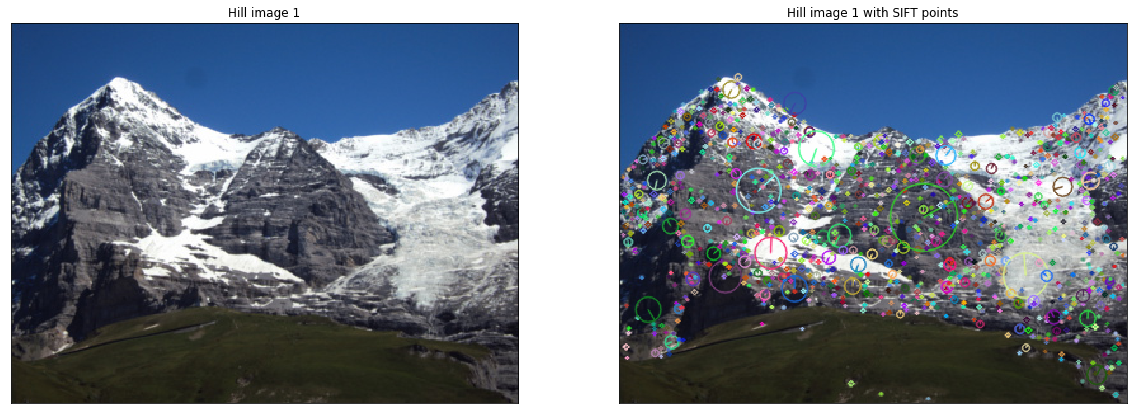

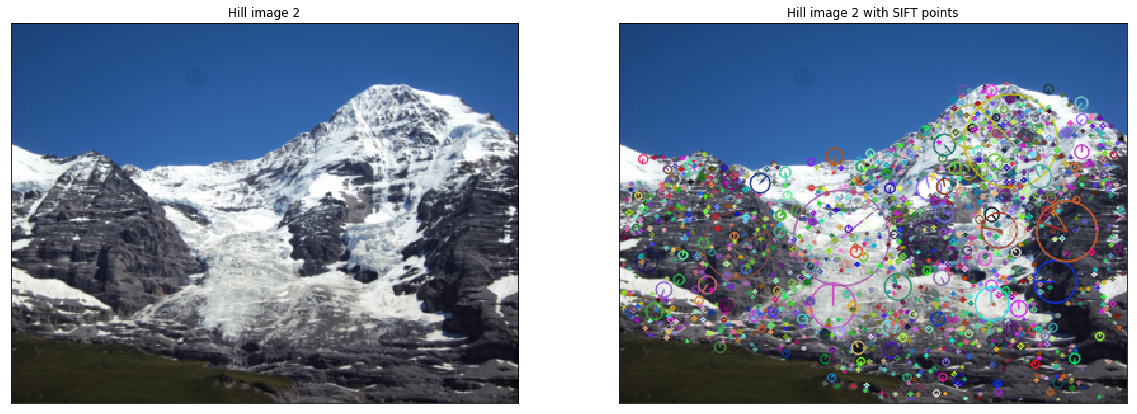

Hill1 SIFT keypoints total, number of descriptors (1254, 128)
Hill2 SIFT keypoints total, number of descriptors (1472, 128)


In [52]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt


# get the images 
hill1 = cv2.imread('./stitching_images/1hill.jpg')
hill2 = cv2.imread('./stitching_images/2hill.jpg')

# convert the images to colour RGB 
hill1 = cv2.cvtColor(hill1, cv2.COLOR_BGR2RGB)
hill2 = cv2.cvtColor(hill2, cv2.COLOR_BGR2RGB)

# copy the image
hill1_cpy = hill1.copy()
hill2_cpy = hill2.copy()

# create a sift object 
sift = cv2.xfeatures2d.SIFT_create()

# detect Sift features and descriptors without masks
keypoints_hill1, descriptors_hill1 = sift.detectAndCompute(hill1, None)
keypoints_hill2, descriptors_hill2 = sift.detectAndCompute(hill2, None)

# draw the keypoints 
cv2.drawKeypoints(hill1, keypoints_hill1, hill1_cpy, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.drawKeypoints(hill2, keypoints_hill2, hill2_cpy, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(20,20))
plt.subplot(121), plt.imshow(hill1)
plt.title('Hill image 1'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(hill1_cpy)
plt.title('Hill image 1 with SIFT points'), plt.xticks([]), plt.yticks([])
plt.show()

plt.figure(figsize=(20,20))
plt.subplot(121), plt.imshow(hill2)
plt.title('Hill image 2'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(hill2_cpy)
plt.title('Hill image 2 with SIFT points'), plt.xticks([]), plt.yticks([])
plt.show()

print('Hill1 SIFT keypoints total, number of descriptors', str(descriptors_hill1.shape))
print('Hill2 SIFT keypoints total, number of descriptors', str(descriptors_hill2.shape))

#### Q2 - Finding the 20 best keypoints

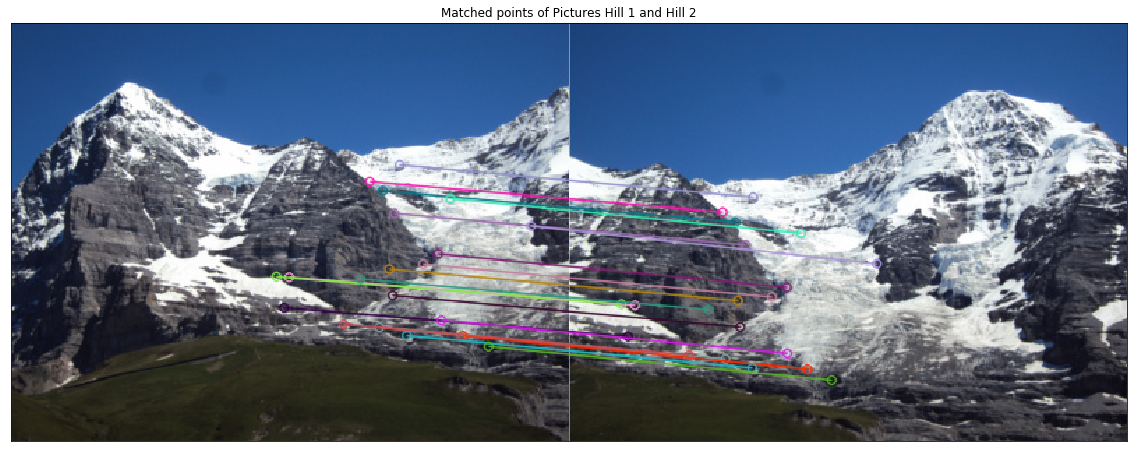

In [108]:
# Match the top 20 features 

# Create a BFMatcher object and match the descriptors 
bf = cv2.BFMatcher()
matches = bf.match(descriptors_hill1, descriptors_hill2)

# Sort them by distance and draw the first 20 matches 
matches = sorted(matches, key=lambda match:match.distance)
matched_image12 = cv2.drawMatches(hill1, keypoints_hill1, hill2, keypoints_hill2, matches[:20], hill1, flags=2)

plt.figure(figsize=(20,20))
plt.imshow(matched_image12)
plt.title('Matched points of Pictures Hill 1 and Hill 2'), plt.xticks([]), plt.yticks([])
plt.show()



#### Q3 - Find the homography using the RANSAC method 

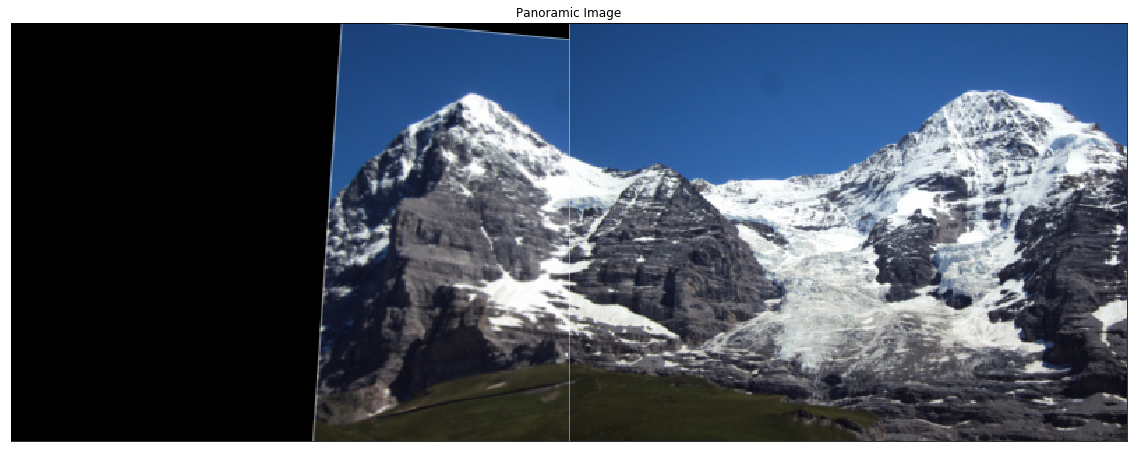

In [117]:
## Seperate the matches into two lists 
arrayMatches = []
for i, match in enumerate(matches):
    arrayMatches.append((match.trainIdx, match.queryIdx))
    
matchesp_hill2 = np.float32([keypoints_hill2[i].pt for (i, __) in arrayMatches])
matchesp_hill1 = np.float32([keypoints_hill1[i].pt for (__, i) in arrayMatches])

# shifts the right image to fit the left image next to it
for i in range(len(matchesp_hill2)):
    matchesp_hill2[i][0] += hill2.shape[1]

# find homography and wrap the images together
homography, __ = cv2.findHomography(matchesp_hill1, matchesp_hill2, cv2.RANSAC, 4)
merged_img = cv2.warpPerspective(hill1, homography, (hill1.shape[1]+hill2.shape[1], hill1.shape[0]))

# copies the exact images that we used for pyramid blending
h1_new = merged_img.copy()
# shifted hill2 image past the right image
# h2_new = np.zeros((hill2.shape[0],hill2.shape[1]+hill1.shape[1],3), dtype=np.uint8)
# h2_new[:hill2.shape[0],hill1.shape[1]:,:] = hill2
merged_img[:hill2.shape[0],hill1.shape[1]:, :] = hill2
h2_new = merged_img.copy()

plt.figure(figsize=(20,20))
plt.subplot(111), plt.imshow(merged_img)
plt.title('Panoramic Image'), plt.xticks([]), plt.yticks([])
plt.show()


#### Q4 - Perform the pyramid image blending  

(300, 800)
(75, 200, 3)
gpla:  (75, 200, 3)
gplb:  (75, 200, 3)
(150, 400, 3)
gpla:  (150, 400, 3)
gplb:  (75, 200, 3)
(300, 800, 3)
gpla:  (300, 800, 3)
gplb:  (150, 400, 3)


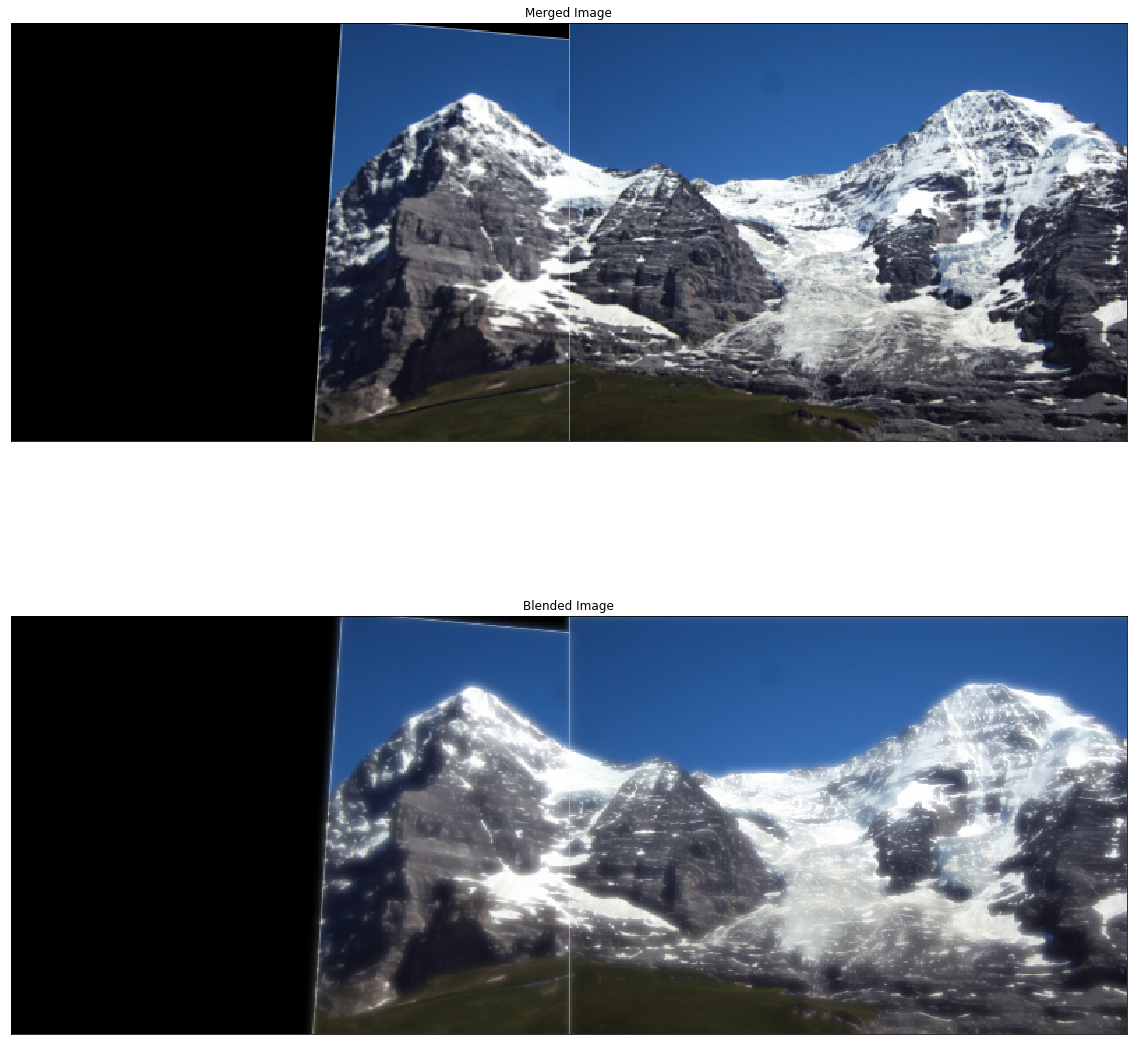

In [145]:
# pyramid blending 

# gaussian mask blur size and pyramid depth size
g_size = 255
depth = 3

# using the modified images we got from the homography step
# h1_new & h2_new
row, column, dpt = h1_new.shape 

# generate the pyramid for hill1
gaussian1 = h1_new.copy()
gauss_pyr1 = [gaussian1]
for x in range(depth):
    gaussian1 = cv2.pyrDown(gaussian1)
    gauss_pyr1.append(gaussian1)
    
# generate the pyramid for hill2
gaussian2 = h2_new.copy()
gauss_pyr2 = [gaussian2]
for x in range(depth):
    gaussian2 = cv2.pyrDown(gaussian2)
    gauss_pyr2.append(gaussian2)
    
# generate the Laplacian pyramid for hill1 and store the last image on top of laplacian pyramid
lap_pyr1 = [gauss_pyr1[depth-1]]
for i in range(depth-1, 0, -1):
    hr = cv2.pyrUp(gauss_pyr1[i], dstsize=(gauss_pyr1[i-1].shape[1], gauss_pyr1[i-1].shape[0]))
    # subtract different levels
    lp = cv2.subtract(gauss_pyr1[i-1], hr, cv2.CV_32F) 
    lap_pyr1.append(lp)

# generate the Laplacian pyramid for hill2 and store the last image on top of laplacian pyramid
# repeat same process as above
lap_pyr2 = [gauss_pyr2[depth-1]]
for i in range(depth-1, 0 , -1):
    hr = cv2.pyrUp(gauss_pyr2[i], dstsize=(gauss_pyr2[i-1].shape[1], gauss_pyr2[i-1].shape[0]))
    lp = cv2.subtract(gauss_pyr2[i-1], hr, cv2.CV_32F)
    lap_pyr2.append(lp)

# add up the images halves together 
lap_pyramid = []
for la, lb in zip(lap_pyr1, lap_pyr2):
    row, column, dpt = la.shape
    # stack the columns on one another
    lp = np.hstack((la[:, :round(column/2)], lb[:, round(column/2):]))
    lap_pyramid.append(lp)

# build Gaussian pyramid from the selected region 
mask = np.zeros((h1_new.shape[0], h1_new.shape[1]))

# create mask and blur it
mask[:, round(h1_new.shape[1]/2):] = 1
mask = cv2.GaussianBlur(mask, (g_size, g_size), 0)

print(mask.shape)
# generate a Gaussian pyramid
gaussian = mask.copy()
gPyr = [gaussian]
for i in range(depth):
    gaussian = cv2.pyrDown(gaussian)
    gPyr.append(gaussian)

# add the images together using the gaussian mask
lapPyr_mask = []
index = 1
# blend the images 
for la, lb in zip(lap_pyr1, lap_pyr2):
    idx = depth - index
    gpla = (1-gPyr[idx].reshape(gPyr[idx].shape[0], gPyr[idx].shape[1], 1)) * la
    gplb = gPyr[idx].reshape(gPyr[idx].shape[0], gPyr[idx].shape[1], 1) * lb
    lp = gpla + gplb
    # convert back to uint8
    lp = np.uint8(lp)
    lapPyr_mask.append(lp)
    index += 1
    
# now reconstruction to put the images together 
reconstruct = lap_pyramid[0]
for i in range(1, depth):
    # upsample current lp image
    reconstruct = cv2.pyrUp(reconstruct)
    # add laplace pyramid to the image
    reconstruct = cv2.add(reconstruct, lap_pyramid[i])
    
# repeat above for the gaussian mask reconstruction
# reconstruct_mask = lapPyr_mask[0]
# for i in range(1, depth):
#     reconstruct_mask = cv2.pyrUp(reconstruct_mask)
#     reconstruct_mask = cv2.add(reconstruct_mask, lapPyr_mask[i])
    
# display image blending results 
plt.figure(figsize=(20,20))
plt.subplot(211), plt.imshow(merged_img)
plt.title('Merged Image'), plt.xticks([]), plt.yticks([])
plt.subplot(212), plt.imshow(reconstruct)
plt.title('Blended Image'), plt.xticks([]), plt.yticks([])
plt.show()




#### Q1 - Computing SURF keypoints and descriptors

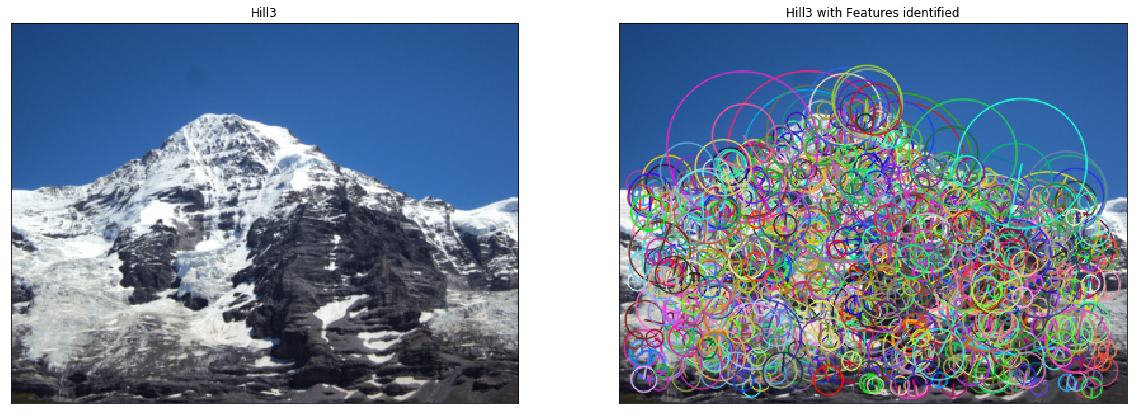

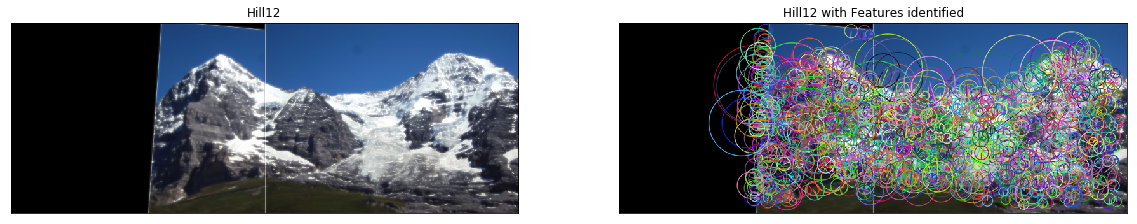

Total Keypoints for Hill3:  879
Total Keypoints for Hill12:  1312


In [27]:
# load hill3 image
hill3 = cv2.imread('./stitching_images/3Hill.jpg')

# convert to grayscale and into RGB
hill3_gray = cv2.cvtColor(hill3, cv2.COLOR_BGR2GRAY)
hill3 = cv2.cvtColor(hill3, cv2.COLOR_BGR2RGB)

# copy image 
hill3_cpy = hill3.copy()

# create SURF object
surf = cv2.xfeatures2d.SURF_create()

# detect SURF features and descriptors
keypoints_hill3, descriptors_hill3 = surf.detectAndCompute(hill3_gray, None)

# draw the keypoints
cv2.drawKeypoints(hill3, keypoints_hill3, hill3_cpy, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# repeat all the steps for hill12 image
hill12 = reconstruct.copy()

hill12_gray = cv2.cvtColor(hill12, cv2.COLOR_RGB2GRAY)
hill12_cpy = hill12.copy()

keypoints_hill12, descriptors_hill12 = surf.detectAndCompute(hill12_gray, None)
cv2.drawKeypoints(hill12, keypoints_hill12, hill12_cpy, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# print(descriptors_hill12)
# print(descriptors_hill3)
# display image and print out SURF keypoints total
plt.figure(figsize=(20,20))
plt.subplot(121), plt.imshow(hill3)
plt.title('Hill3'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(hill3_cpy)
plt.title('Hill3 with Features identified'), plt.xticks([]), plt.yticks([])
plt.show()

plt.figure(figsize=(20,20))
plt.subplot(221), plt.imshow(hill12)
plt.title('Hill12'), plt.xticks([]), plt.yticks([])
plt.subplot(222), plt.imshow(hill12_cpy)
plt.title('Hill12 with Features identified'), plt.xticks([]), plt.yticks([])
plt.show()



print('Total Keypoints for Hill3: ', str(len(keypoints_hill3)))
print('Total Keypoints for Hill12: ', str(len(keypoints_hill12)))

#### Q2 - Found the 20 best keypoints

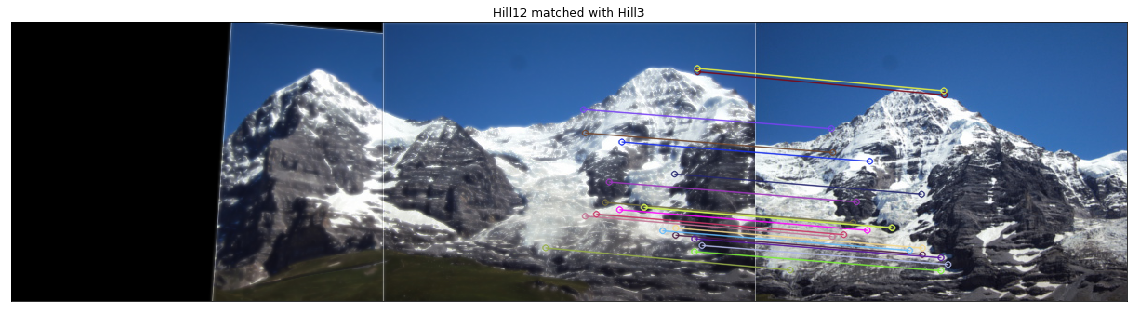

In [28]:
bf = cv2.BFMatcher()

# reuse the past BF object and match the descriptors
matches = bf.match(descriptors_hill12, descriptors_hill3)

# sort them by distance
matches = sorted(matches, key=lambda match:match.distance)

# draw only the first top 20 matches 
matched_img123 = cv2.drawMatches(hill12, keypoints_hill12, hill3, keypoints_hill3, matches[:20], hill12, flags=2)

# display image with matches
plt.figure(figsize=(20,20))
plt.imshow(matched_img123)
plt.title('Hill12 matched with Hill3'), plt.xticks([]), plt.yticks([])
plt.show()


#### Q3 - Find the homography using RANSAC method


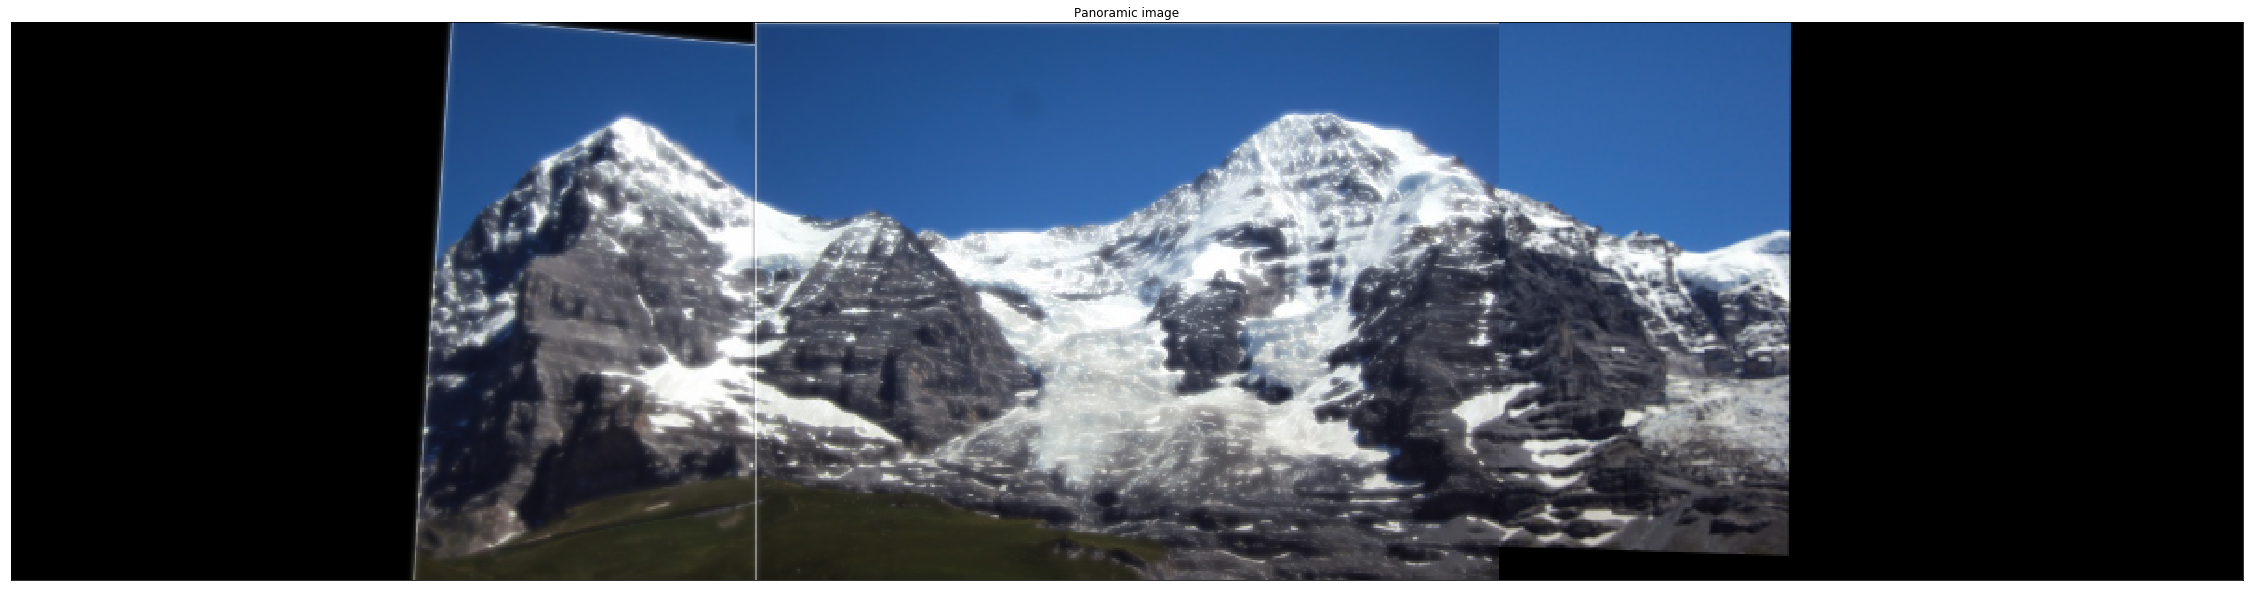

In [58]:
# Seperate the matches into two lists then package them into a tuple 
goodMatches = []
for i, match in enumerate(matches):
    goodMatches.append((match.trainIdx, match.queryIdx))
    
matchesp_hill3 = np.float32([keypoints_hill3[i].pt for (i, __) in goodMatches])
matchesp_hill12 = np.float32([keypoints_hill12[i].pt for (__, i) in goodMatches])

# find the homography and wrap the images on one another
homography, __ = cv2.findHomography(matchesp_hill3, matchesp_hill12,cv2.RANSAC, 4)
merged_img = cv2.warpPerspective(hill3, homography, (hill3.shape[1]+hill12.shape[1], hill3.shape[0]))

hill3_new = merged_img.copy()
hill12_new = hill12.copy()
merged_img[:,:hill12.shape[1],:] = hill12

plt.figure(figsize=(40,40))
plt.imshow(merged_img)
plt.title("Panoramic image"), plt.xticks([]), plt.yticks([])
plt.show()

#### Q4 - Linear Image Blending

In [ ]:
# compute the image blending with hill3_new & hill12_new

# find the width and height of the image
col, row = hill12_new.shape[0:2]
# image with direct connecting each half
real = np.hstack((hill12_new[:, :round()]))

#### Reasoning Questions 
##### Question 1 
Sift finds both a detector and a desciptor in order to identify features. The detector uses the an approximation of the laplacian called the difference of gaussian (DoG) and this detects the center of interesting blob like features. Surf is basically a fast approximation of Sift and it's written in its name. It's known that Surf can be up to 3-6 times faster than Sift. However, with an increase in speed it is nto as robust as Sift. Sift uses different measures in order to calculate location and the scale of potential keypoints whereas as Surf uses the determinant Hessian. This causes SURF to catch a more keypoints compared to Sift whom finds less key points but the keypoints are all interesting points.

##### Question 2
Feathering is quick and easy to implement and it is not a complicated process to combine two images. However it takes the weighted average of every pixel but the weight of the pixel is dependant on the distance from the map. For these reasons it does not always successfully blend the image together because it requires a balance between the smoothing low frequencies for a nice blend but being capable of having a sharp/clear trainsistion. In the case for the mountain the colours are quite similar in the sky therefore the linear blending is excels in these occasions. Also the blending is highly dependant on the window size for the blending. Finding the window size for feathering is difficult process which requires a some testing in order to find the Optimal Window size in order to avoid seams and avoid ghosting. 

Pyramid blending is another method which breaks down the image into multiple levels like a pyramid with decreasing number of pixels as you go down the levels. Pyramid blending is definetely a lot better at providing a cleaner and sharper final image for cases with high and low frequencies involved for example the contrast from the white snow and the dark rocks. One of the main problems with pyramid blending is the extra code and memory it takes to create the image. The length of the execution is dependant on the level/depth of the pyramid.

##### Question 3


##### Question 4